In [2]:
import os
import shutil
import numpy as np
from pathlib import Path
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

from random import sample
import  cv2
from pre_process_cropping_AP import BEX_cropping

In [3]:
# Get base project directory
project_path = Path(os.getcwd()).parent.parent
datapath = (project_path /'data/processed/')

CLASSES = {0 : 'yes', 1 : 'no'}

In [3]:
# Loops through pathlist and reads and resizes images
def read_image(pathlist : list, size : int)-> list:
    data = []
    for path in pathlist:
        image=load_img(path, color_mode='grayscale', target_size=(size, size))
        image=img_to_array(image)
        image=image/255.0
        data.append(image)
    return data

# Makes input and label data from folder locations.
# Loops through location "subfolder/CLASSES"
def get_sets(subfolder : str, CLASSES : dict, size : int) -> tuple[list, list]:
    folder_paths = []
    folder_labels = []
    labels = []
    for k,v in CLASSES.items():
        # input datapath generation
        folder_paths += list((datapath / f"2_split_{v}/{subfolder}").rglob("*"))
    # Label data generation
    folder_labels = [0 if x.stem.split('_')[1] == 'yes' else 1 for x in folder_paths]
    # Extract images from datapaths
    img_list = read_image(folder_paths, size)

    return img_list, folder_labels

Hjälpfunktion. Returnerar lista med filer från sökväg

In [ ]:
def get_files(p_path) -> list:
    """ returner alla filer i mappen som kommer som inparameter """

    p = p_path.glob('*/')
    file_paths = [x for x in p if x.is_file()]
    return file_paths

In [28]:
doubles_y = Path(r"data/raw/dataset_1\removed_doubles/yes")
doubles_n = Path(r"data/raw/dataset_1\removed_doubles/no")
process_y = Path(r"data/processed/1_cropped_yes")
process_n = Path(r"data/processed/1_cropped_no")

work_path_n = project_path / doubles_n
work_path_y = project_path / doubles_y

nr_of_doubles_n = len(get_files(work_path_n))
nr_of_doubles_y = len(get_files(work_path_y))

work_path_n = project_path / process_n
work_path_y = project_path / process_y



nr_of_process_n = len(get_files(work_path_n))
nr_of_process_y = len(get_files(work_path_y))


print(f"Antalet bortplockade dubbletter Y: {nr_of_doubles_y}")
print(f"Antalet bortplockade dubbletter N: {nr_of_doubles_n}")
print("-----------------")
print(f"Kvarvarande bilder Y: {nr_of_process_y}")
print(f"Kvarvarande bilder N: {nr_of_process_n}")

Antalet bortplockade dubbletter Y: 19
Antalet bortplockade dubbletter N: 21
-----------------
Kvarvarande bilder Y: 133
Kvarvarande bilder N: 76


## Croppingteknik
Målet är att beskära bilden maximalt från redundanta mörka fält som bildas runt skallen. Först letas mittpunkten i bilden ut, och därefter söker vi av ut mot bildens kant.   Tekniken baseras på två metrics:     
**Standardavvikelse** När det inte länge finns hög varians i en avsökt rad så minskar standardavvikelsen. När vi nåt ett satt tröskelvärde avbryter vi sökning och behåller det som yttermått.   
**Pixelvärde** samma teknik som ovan men i detta fallet sätts alla pixelvärdet till noll vid ett visst tröskelvärdevärde. Därefter summeras raden och mäts (återigen mot) mot ett tröskelvärde för att beräkna om raden ska ses som en kant eller inte.   
   
Slutligen kontrolleras vilken av metoderna som ger bäst beskärning och den metoden används.

---------------------------
Hjälpfunktioner för att plotta bilder

In [29]:
def get_nr_random(size, length_int) -> list:
    """ reurnerar size antal slumpade tal från lista som length_int lång """

    lst= list(np.arange(0, length_int))
    return_lst = sample(lst, size)
    return return_lst
#--------------------------------------------------------------------------------------
def print_sheet(str_files, idxs, str_title):
    """" skapar ett grid med bilder pre-crop, post-crop och storlekar """
    
    fig, ax  = plt.subplots(len(idxs), 3, figsize = (12,12))
    fig.suptitle(str_title, fontsize = 22)
    for idx in range(nr_of_pics):
        f_name_y = str_files[idxs[idx] ]
        img_y = cv2.imread(str(f_name_y))
         
        obj = BEX_cropping(f_name_y)
        cropped_img = obj.calculate_cropping()
        ax[idx][0].set_title(f_name_y.stem)
        ax[idx][0].imshow(img_y)
        ax[idx][1].set_title(f_name_y.stem +"-cropped")
        ax[idx][1].imshow(cropped_img, cmap="gray")
        ax[idx][2].text(.1, .8, f"original size: {img_y.shape[:2]}")
        ax[idx][2].text(.1, .6, f"cropped  size: {cropped_img.shape[:2]}")
        ax[idx][2].axis('off')

Sätter samman två subplottar och visar bilder före efter cropping

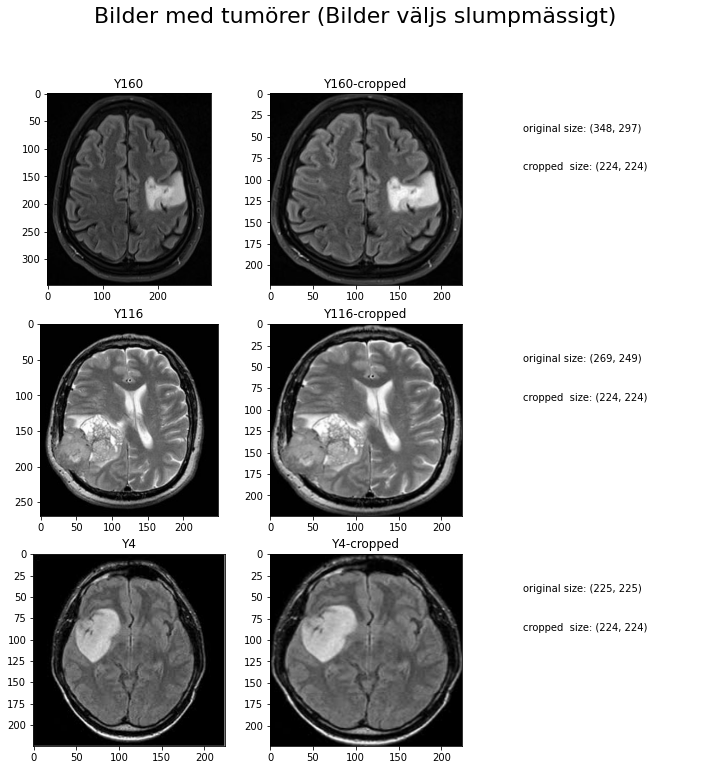

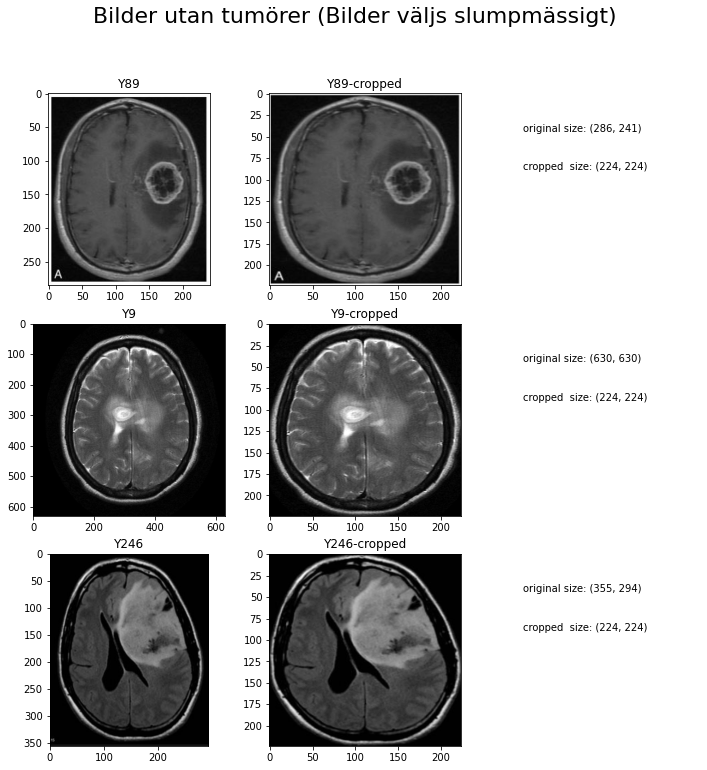

In [31]:
nr_of_pics  = 3                 # antalet bilder som slumpas ut ur för visning (antalet för varje kategori)

yes_path = Path(r"data/raw/dataset_1\brain_tumor_dataset\yes")
no_path  = Path(r"data/raw/dataset_1\brain_tumor_dataset\no")

work_path_n = project_path / no_path
work_path_y = project_path / yes_path

yes_files = get_files(work_path_y)
no_files  = get_files(work_path_n)

rand_yes = get_nr_random(nr_of_pics, len( yes_files))
rand_no  = get_nr_random(nr_of_pics, len(no_files))

print_sheet(yes_files, rand_yes, "Bilder med tumörer (Bilder väljs slumpmässigt)")
print_sheet(no_files,  rand_no,  "Bilder utan tumörer (Bilder väljs slumpmässigt)")

# Dataset inspect

In [4]:
# Read images to variables
size = 224
X_train, y_train = get_sets('train', CLASSES, size)
X_val, y_val = get_sets('val', CLASSES, size)
X_test, y_test = get_sets('test', CLASSES, size)

In [5]:
# Dataset distribution
print(len(X_train), len(y_train))
print(len(X_val), len(y_val))
print(len(X_test), len(y_test))

125 125
42 42
42 42


In [6]:
# Shapes of dataset
print(f"shape train x: {np.array(X_train).shape} label shape: {np.array(y_train).shape} ")
print(f"shape validation x: {np.array(X_val).shape} label shape: {np.array(y_val).shape} ")
print(f"shape test x: {np.array(X_test).shape} label shape: {np.array(y_test).shape} ")

shape train x: (125, 224, 224, 1) label shape: (125,) 
shape validation x: (42, 224, 224, 1) label shape: (42,) 
shape test x: (42, 224, 224, 1) label shape: (42,) 


In [7]:
# Label distribution
print(f"Train yes: {np.unique(y_train, return_counts=True)[1][0]} Train no: {np.unique(y_train, return_counts=True)[1][1]}")
print(f"Validation yes: {np.unique(y_val, return_counts=True)[1][0]} Validation no: {np.unique(y_val, return_counts=True)[1][1]}")
print(f"Test yes: {np.unique(y_test, return_counts=True)[1][0]} Test no: {np.unique(y_test, return_counts=True)[1][1]}")

Train yes: 79 Train no: 46
Validation yes: 24 Validation no: 18
Test yes: 30 Test no: 12


In [8]:
# Unique labels
print(f"Possible labels: {np.unique(y_train+ y_val + y_test)}")


Possible labels: [0 1]


In [9]:
# Max min labeldata expected 0 - 1 as a normalization was done during read of the files
print(f"X min value: {np.amin(X_test)}\nX max value: {np.amax(X_test)}")

X min value: 0.0
X max value: 1.0


# Picture inspect

In [10]:
def classplot(nClass:int, subc:int, subr:int, x:list, y:np.array):
    """Plots random pictures(x) from set class(found in y). Number of pictures subc * subr

    Args:
        nClass (int): Classnumber
        subc (int): Plot number of columns
        subr (int): Plot number of rows
        x (list): Image list to plot images from
        y (np.array): Label list to find indexnumbers from
    """
    randclass_list = np.random.choice(np.array(np.where(np.asarray(y) == nClass))[0], subc*subr, replace=False)

    plt.figure(figsize=(8,8))
    for i, num in enumerate(randclass_list):
        plt.subplot(subc,subr, i+1)
        plt.imshow(x[num], cmap='gray')
        plt.title("Class {}".format(y[num]))

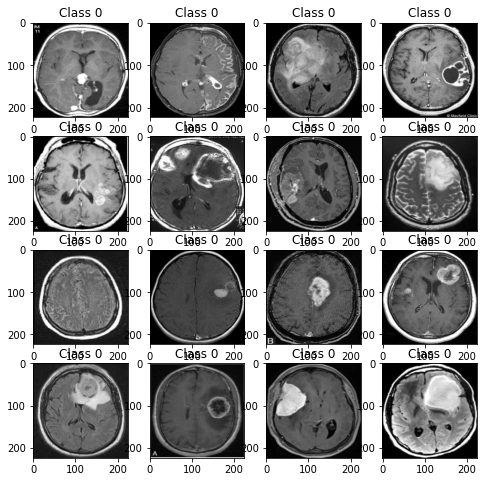

In [11]:
classplot(0, 4, 4, X_train, y_train)

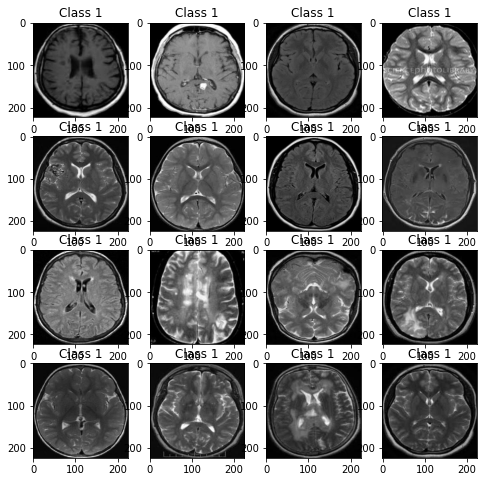

In [12]:
classplot(1, 4, 4, X_train, y_train)

The variation of contrast are big even within the same areas of the brains. Sometimes the brain wrinkles are darker areas and sometimes they are lit up. 
This seems to be the case of both classes. So well need to see if its possible to normalize to get about the same result.

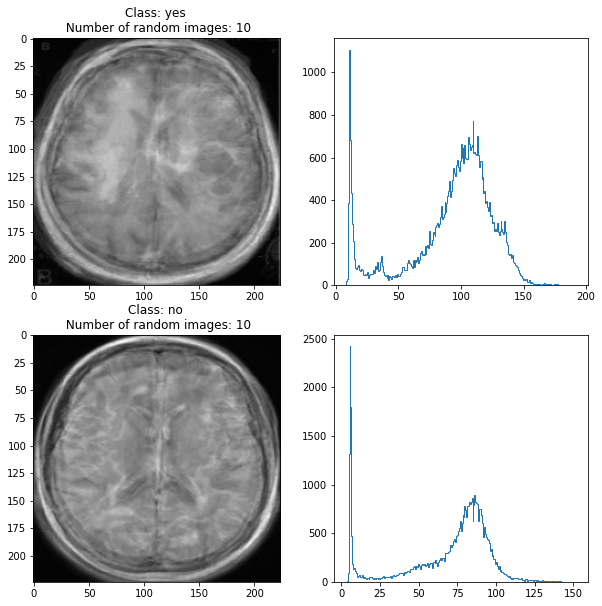

In [13]:
image_num = 10

fig, ax = plt.subplots(2,2, figsize=(10,10))

for i, k in enumerate(CLASSES):
    index_list = np.random.choice(np.asarray(np.where(np.asarray(y_train) == k)).ravel(), image_num, replace=False)
    histmean = np.sum(np.array(X_train)[index_list]*255, axis=0)/len(index_list)
    ax[i][0].set_title(f"Class: {CLASSES[k]} \n Number of random images: {image_num}")
    ax[i][0].imshow(histmean, cmap='gray')
    ax[i][1].hist(histmean.ravel(), bins = 255, histtype='step')


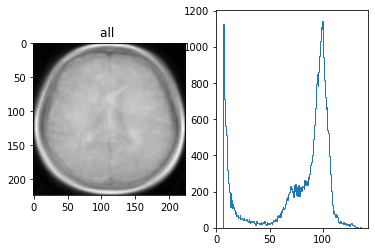

In [14]:
fig, ax = plt.subplots(1,2)
ax[0].set_title('all ')
ax[0].imshow(np.sum(X_train, axis=0)/len(X_train), cmap='gray')
ax[1].hist(np.asarray(np.sum(np.asanyarray(X_train)*255, axis=0)/len(X_train)).flatten(), bins=255, histtype='step');

# Bias för ögonhålor?   
I vårt städade dataset finns bilder där man ser ögon / ögonhålor. Det har slumpat(?) sig så, att ögonbilder endast förekommer i delen *med* tumörer. Vid okulär besiktning ser man måga tumörer har en cirkulär form och vi ställer oss frågande till vad det kommer innebära för resultatet på våra modeller.   
   
      
Sex bilder har ögonhålor med. Här under kommer bild på en förekomst. 

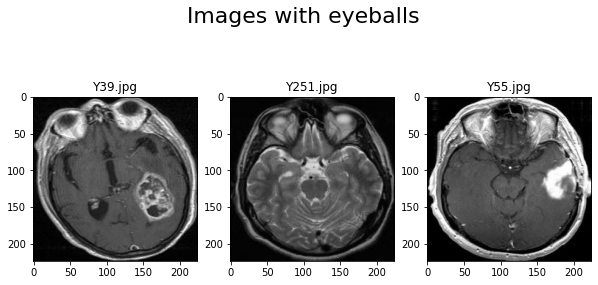

In [11]:
def plot_eyes():
    project_path = Path(os.getcwd()).parent.parent
    datapath = (project_path /'data/processed/1_cropped_yes')
    f_name = ['Y39.jpg','Y251.jpg','Y55.jpg']
    fig,ax = plt.subplots (1,len(f_name),figsize = (10,5))
    fig.suptitle("Images with eyeballs", fontsize = 22)
    for idx, f_eyes in enumerate(f_name):
        img = cv2.imread(str(datapath / f_eyes))
        ax[idx].set_title(f_eyes)
        ax[idx].imshow(img)

plot_eyes()